In [201]:
import re
from tqdm import tqdm_notebook as tqn
import numpy as np
import pandas as pd
import tensorflow as tf
from dataset import Dataset, DatasetIndex, Batch, action, model
from matplotlib import pyplot as plt
%matplotlib inline

# linear regression

In [221]:
def generate_data(lenght = 10,seed = 10):
    y = np.linspace(0,10,lenght)
    np.random.seed(seed)
    X = y + np.random.random(lenght) - 0.5
    return X,y

In [262]:
class MyBatch(Batch):
    def __init__(self, index, *args, **kwargs):
        super().__init__(index, *args, **kwargs)
    
    @property
    def components(self):
        return 'x', 'y','W','b','loss'
    
    @action
    def generate(self, lenght = 10):
        if self.x == None or self.y == None:
            self = self.load(lenght)
            
        self.x, self.y = self.x[self.indices], self.y[self.indices]
        return self
    @action
    def load(self, lenght = 10, fmt = None):
#         if fmt == 'csv':
#             self.x = list(map(float,open('{}_x.{}'.format(src,fmt),'r').read().split('\n')[:-1]))
            
#             self.y = list(map(float,open('{}_y.{}'.format(src,fmt),'r').read().split('\n')[:-1]))
        
        self.x, self.y = generate_data(lenght)
        return self
    
    @model()
    def linear_model():
        X = tf.placeholder(name='input',dtype=tf.float32)
        y = tf.placeholder(name='true_y',dtype=tf.float32)
        
        W = tf.Variable(np.random.randint(-1,1,size=1),name='weight',dtype=tf.float32)
        b = tf.Variable(np.random.randint(-1,1),dtype=tf.float32)

        predict = tf.multiply(W,X,name='output') + b
        loss = tf.reduce_mean(tf.square(predict - y))

        optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.007)
        train = optimize.minimize(loss)
        
        return [[X, y],[train, loss],[W,b]]
    
    @action(model='linear_model')
    def train_model(self,model,session):
       # print(self.x,self.y)
        X,y = model[0]
        optimizer, cost = model[1]
        params = model[2]
#         for i in range(1000):
            #print('before step {}, y is {}'.format(i, session.run(y)))
        _, loss, params = session.run([optimizer, cost, params], feed_dict={X:self.x, y: self.y})
        self.W = params[0][0]
        self.b = params[1]
        self.loss = loss
        print('loss: {} | params: {}, {}'.format(loss, self.W, self.b))
        return self

loss: 3.6033782958984375 | params: -0.9885286688804626, -0.9745132923126221
loss: 16.510082244873047 | params: -0.8956701755523682, -0.9183984994888306
16.5101


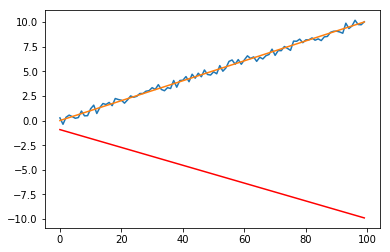

loss: 31.859106063842773 | params: -0.6979867219924927, -0.8398746848106384
loss: 45.46672439575195 | params: -0.3719746768474579, -0.7457035183906555
45.4667


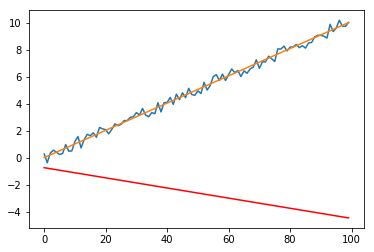

loss: 48.0316047668457 | params: 0.06684690713882446, -0.6488224267959595
loss: 33.5230827331543 | params: 0.5164219737052917, -0.5678489804267883
33.5231


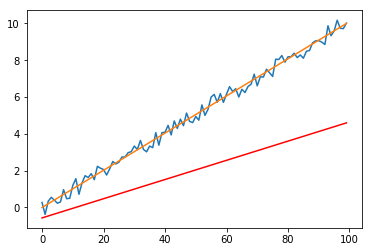

loss: 14.06578254699707 | params: 0.8553977012634277, -0.5154374241828918
loss: 2.6939613819122314 | params: 1.0247128009796143, -0.4926864504814148
2.69396


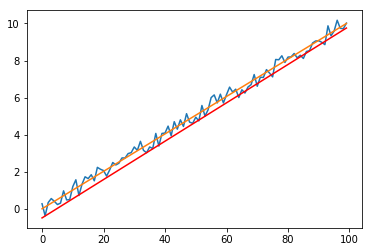

loss: 0.18600070476531982 | params: 1.0700092315673828, -0.48726940155029297
loss: 0.11754874885082245 | params: 1.0458307266235352, -0.48965612053871155
0.117549


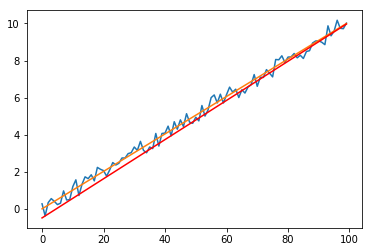

In [263]:
#new_model = MyBatch(np.arange(10)).load('data')#.train_model(tf.Session())
len_data = 100
ix = DatasetIndex(np.arange(len_data))

dset = Dataset(ix,MyBatch)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
i = 0
X,y = generate_data(len_data)
for batch in tqn(dset.gen_batch(10,n_epochs=1)):
   # print(i.indices)
    batch.generate(len_data).train_model(sess)
    i +=1
    if i == 2:
        print(batch.loss)
        i = 0
        plt.plot(X)
        plt.plot(y)
        plt.plot(batch.W * y + batch.b, c ='r')
        plt.show()